In [28]:
%matplotlib inline


## Load data


In [44]:
import numpy as np 
import pandas as pd 
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
from glob import glob
from skimage.io import imread
from livelossplot import PlotLossesKerasTF
from functools import *


import random
os.environ["CUDA_VISIBLE_DEVICES"]='1'
BASE_IMG_PATH=os.path.join('hecktor-master','data','resampled')
BATCH_SIZE = 2
INPUT_SHAPE = (144,144,144,2)
PROJECT_NAME = 'hector'
random.seed(42)
random_seed = 42
AUG_RATE = 0.25
AUGMENTATION_OPS = [
    lambda t: np.rot90(t, axes=(1, 2), k=1),  # 90 degree rotation
    lambda t: np.rot90(t, axes=(1, 2), k=2),  # 180 degree rotation
    lambda t: np.rot90(t, axes=(1, 2), k=3),  # 270 degree rotation
    lambda t: np.flip(t, axis=0),  # Axial flip
    lambda t: np.flip(t, axis=1),  # Sagittal flip
    lambda t: np.flip(t, axis=2)  # Coronal flip
]


In [30]:
glob(os.path.join(BASE_IMG_PATH,'*'))


['hecktor-master/data/resampled/CHGJ073_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ035_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHGJ082_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS069_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHGJ083_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS052_ct.nii.gz',
 'hecktor-master/data/resampled/CHUM047_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ025_ct.nii.gz',
 'hecktor-master/data/resampled/CHUS041_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS097_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS046_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS055_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHMR013_ct.nii.gz',
 'hecktor-master/data/resampled/CHUS015_ct.nii.gz',
 'hecktor-master/data/resampled/CHUM027_pt.nii.gz',
 'hecktor-master/data/resampled/CHUS015_pt.nii.gz',
 'hecktor-master/data/resampled/CHGJ053_ct_gtvt.nii.gz',
 'hecktor-master/data/resampled/CHUS098_ct.nii.gz',
 'hecktor-master/data/resampled/CH

In [31]:
# show some of the files
all_ct_images= glob(os.path.join(BASE_IMG_PATH,'*ct.nii.gz'))
all_pt_images = [x.replace('ct.nii.gz', 'pt.nii.gz') for x in all_ct_images]
all_mask_images = [x.replace('ct.nii.gz', 'ct_gtvt.nii.gz') for x in all_ct_images]

rand_index = np.random.randint(0, len(all_ct_images))
print(len(all_ct_images),' matching files found:',all_ct_images[rand_index], all_pt_images[rand_index])
print(len(all_mask_images),' matching files found:',all_ct_images[rand_index], all_mask_images[rand_index])


201  matching files found: hecktor-master/data/resampled/CHUM001_ct.nii.gz hecktor-master/data/resampled/CHUM001_pt.nii.gz
201  matching files found: hecktor-master/data/resampled/CHUM001_ct.nii.gz hecktor-master/data/resampled/CHUM001_ct_gtvt.nii.gz


(141, 141, 144)


Text(0.5, 1.0, 'Mask')

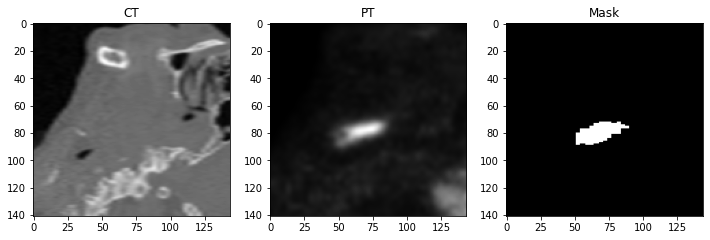

In [32]:
%matplotlib inline
try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')
    
test_ct=np.asarray(nib.load(all_ct_images[rand_index]).dataobj)
test_pt=np.asarray(nib.load(all_pt_images[rand_index]).dataobj)
test_mask=np.asarray(nib.load(all_mask_images[rand_index]).dataobj)
print(test_ct.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))

ax1.imshow(test_ct[test_ct.shape[0]//2], cmap = 'gray')
ax1.set_title('CT')
ax2.imshow(test_pt[test_pt.shape[0]//2], cmap = 'gray')
ax2.set_title('PT')
ax3.imshow(test_mask[test_mask.shape[0]//2], cmap = 'gray')
ax3.set_title('Mask')

In [33]:
def make144(image):
    new_image = skimage.transform.resize(image, (144,144,144), mode= 'edge')
    return new_image

def preprocess(image):
    if image.shape != (144,144,144):
        image = make144(image)
    new_image = (image - image.mean())/image.std()
    
    return new_image[..., np.newaxis]
print(test_pt.max(), test_pt.min(),test_pt.shape)
new_img = preprocess(test_pt)
print(new_img.max(), new_img.min(),new_img.shape)

19.486927 -0.0016708996 (141, 141, 144)
14.59043 -0.83969265 (144, 144, 144, 1)


In [34]:
data = preprocess(test_pt)
data = np.concatenate((data, preprocess(test_pt)), -1)
data.shape

(144, 144, 144, 2)

In [35]:
#check if ct, pt, mask have same numbers.

from sklearn.model_selection import train_test_split

if not len(all_ct_images) == len(all_pt_images) == len(all_mask_images):
    print(len(all_ct_images), len(all_pt_images), len(all_mask_images))
    raise ValueError('ct,pt,mask number not match')

data_list_index = range(len(all_ct_images))
train_data_list, val_data_list = train_test_split(data_list_index, test_size = 0.2, random_state = 1)


In [36]:
def get_augment_operations(random_state, probability=.25):
    """
    Return a function that can be applied for augmenting a tensor.
    Included operations are:
        - flipping (axial, sagittal and coronal);
        - rotation (90, 180 and 720).
    Each of the six operations has a certain probability to be included for 
    augmentation.
    :param random_state: random state.
    :param probability: probability for operation inclusion.
    :return: function to apply to tensor.
    """
    probabilities = random_state.uniform(size=len(AUGMENTATION_OPS))
    operations = [
        f for p, f in zip(probabilities, AUGMENTATION_OPS) if p > probability
    ]

    def _wrapped(x):
        augmented = reduce(lambda t, f: f(t), operations, x)
        assert augmented.shape == x.shape
        return augmented

    return _wrapped

# Augment
#f = get_augment_operations(random_state, augment_probability)
#x = f(x)
#y = f(y)

In [37]:
import tensorflow as tf


def tf_data_generator(file_list, batch_size = 2, augment_rate = 0):

    i = 0
    j = 0
    if augment_rate!=0:
        #if we want to augmenation
        k = int(len(file_list) * augment_rate)
        indicies = random.sample(range(len(file_list)), k)
        aug_list = [file_list[i] for i in indicies]
            
    while True:
        
        if i*batch_size >= (len(file_list) * (1 + augment_rate)):  
            i = 0
            j = 0
            np.random.shuffle(file_list)
            
        if augment_rate != 0 and i*batch_size >= len(file_list):  
            # if data in augmentation list 
            file_chunk = aug_list[j*batch_size:(j+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:   
                ct=np.asarray(nib.load(all_ct_images[file]).dataobj)
                _pt=np.asarray(nib.load(all_pt_images[file]).dataobj)
                _mask=np.asarray(nib.load(all_mask_images[file]).dataobj)
                
                img = preprocess(_ct)
                img = np.concatenate((img, preprocess(_pt)), -1)
                random_state = np.random.RandomState()
                f = get_augment_operations(random_state)
                _aug_img = f(img)
                
                _mask = make144(_mask)
                _aug_mask = f(_mask)

                data.append(_aug_img) 
                labels.append(_aug_mask)
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1
            j = j + 1

        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:
                _ct=np.asarray(nib.load(all_ct_images[file]).dataobj)
                _pt=np.asarray(nib.load(all_pt_images[file]).dataobj)
                _mask=np.asarray(nib.load(all_mask_images[file]).dataobj)
                
                img = preprocess(_ct)
                img = np.concatenate((img, preprocess(_pt)), -1)
                data.append(img) 
                
                _mask = make144(_mask)
                labels.append(_mask)
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1
            
batch_size = BATCH_SIZE
augment_rate = 0.25
#tf_data_generator(train_data_list)


train_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [train_data_list, batch_size, augment_rate],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144)))        

valid_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [val_data_list, batch_size],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144))) 

#test the data generator
num = 0
for data, labels in train_dataset:
    print(data.shape, labels.shape)
    print(labels.shape)

    num = num + 1
    if num > 7: break
print("testing valid pipeline")  
for data, labels in valid_dataset:
    print(data.shape, labels.shape)

    num = num + 1
    if num > 7: break

(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
(2, 144, 144, 144, 2) (2, 144, 144, 144)
(2, 144, 144, 144)
testing valid pipeline
(2, 144, 144, 144, 2) (2, 144, 144, 144)


## Densely 3D Unet

In [14]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


def denseBlock(t, nb_layers):
    for _ in range(nb_layers):
        tmp = t
        t = BatchNormalization(axis=1,
                                gamma_regularizer=l2(0.0001),
                                beta_regularizer=l2(0.0001))(t)

        t = Activation('relu')(t)
        t = Conv3D(16, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = concatenate([t, tmp])
    return t

def transitionDown(t, nb_features):
    t = BatchNormalization(axis=1,
                            gamma_regularizer=l2(0.0001),
                            beta_regularizer=l2(0.0001))(t)
    t = Activation('relu')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    t = Dropout(0.2)(t)
    #t = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same', data_format='channels_last')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1),strides=(2,2,1), padding='same', data_format='channels_last')(t)
    
    return t

def Tiramisu3D(layer_per_block, n_pool=4, growth_rate=16):
    input_layer = Input(shape=INPUT_SHAPE)
    t = Conv3D(48, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)

    #dense block
    nb_features = 48
    skip_connections = []
    for i in range(n_pool):
        t = denseBlock(t, layer_per_block[i])
        skip_connections.append(t)
        nb_features += growth_rate * layer_per_block[i]
        t = transitionDown(t, nb_features)

    t = denseBlock(t, layer_per_block[n_pool]) # bottle neck

    skip_connections = skip_connections[::-1] #subvert the array

    for i in range(n_pool):
        keep_nb_features = growth_rate * layer_per_block[n_pool + i]
        t = Conv3DTranspose(keep_nb_features, strides=(2,2,1), kernel_size=(3, 3, 3), padding='same', data_format='channels_last')(t) # transition Up
        t = concatenate([t, skip_connections[i]])

        t = denseBlock(t, layer_per_block[n_pool+i+1])

    t = Conv3D(12, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    output_layer = Activation('softmax')(t)
    return Model(inputs=input_layer, outputs=output_layer)

layer_per_block =  [3, 4, 5, 6, 7, 6, 5, 4, 3]
#layer_per_block = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
tiramisu = Tiramisu3D(layer_per_block)

tiramisu.summary()
#plot_model(model, to_file='model.png')



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 144, 144, 14 0                                            
__________________________________________________________________________________________________
conv3d_53 (Conv3D)              (None, 144, 144, 144 2640        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 144, 144, 144 576         conv3d_53[0][0]                  
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 144, 144, 144 0           batch_normalization_47[0][0]     
____________________________________________________________________________________________

## Conv block

In [15]:
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate


def handle_block_names(stage, cols):
    conv_name = 'decoder_stage{}-{}_conv'.format(stage, cols)
    bn_name = 'decoder_stage{}-{}_bn'.format(stage, cols)
    relu_name = 'decoder_stage{}-{}_relu'.format(stage, cols)
    up_name = 'decoder_stage{}-{}_upsample'.format(stage, cols)
    merge_name = 'merge_{}-{}'.format(stage, cols)
    return conv_name, bn_name, relu_name, up_name, merge_name


def ConvRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = Conv3D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name)(x)
        x = Activation('relu', name=relu_name)(x)
        return x
    return layer


def Upsample3D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = UpSampling3D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer


def Transpose3D_block(filters, stage, cols, kernel_size=(3,3,3), upsample_rate=(2,2,2),
                      transpose_kernel_size=(4,4,4), use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = Conv3DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer

# Attention gate input

In [38]:
def attention_block_3d(x, g, inter_channel, data_format='channels_last'):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv3D(inter_channel, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv3D(inter_channel, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv3D(1, [1, 1, 1], strides=[1, 1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x

## Unet ++

In [39]:
"""import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

smooth = 1.
dropout_rate = 0.5

########################################
# 3D Standard
########################################

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv3D(nb_filter, (kernel_size, kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv3D(nb_filter, (kernel_size, kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x


def Nest_Net3D(INPUT_SHAPE, num_class=1, att_input= False, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'elu'

    inputs = Input(shape=INPUT_SHAPE, name='main_input')

    if att_input:
        att = attention_block_3d(inputs[...,0,np.newaxis], inputs[...,1, np.newaxis], inter_channel=1)
        img_input = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(att)
    else:
        img_input = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
        

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool2')(conv2_1)

    up1_2 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=-1)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool3')(conv3_1)

    up2_2 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=-1)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=-1)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool4')(conv4_1)

    up3_2 = Conv3DTranspose(nb_filter[2], (2, 2, 2), strides=(2, 2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=-1)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=-1)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=-1)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv3DTranspose(nb_filter[3], (2, 2, 2), strides=(2, 2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=-1)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv3DTranspose(nb_filter[2], (2, 2, 2), strides=(2, 2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=-1)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=-1)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=-1)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=[nestnet_output_4])

    return model

model =  Nest_Net3D(INPUT_SHAPE,  num_class=1, att_input= True, deep_supervision=True)
model.summary(line_length = 100)"""

"import tensorflow as tf\nimport tensorflow.keras as keras\n\nfrom tensorflow.keras import Model, Input\nfrom tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply\nfrom tensorflow.keras.optimizers import Adam\n\n\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, MaxPooling3D\nfrom tensorflow.keras.layers import Conv3D, Conv3DTranspose\nfrom tensorflow.keras.layers import BatchNormalization\nfrom tensorflow.keras.layers import Activation, Dropout\nfrom tensorflow.keras.layers import concatenate\nfrom tensorflow.keras import backend as K\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras.utils import plot_model\n\nsmooth = 1.\ndropout_rate = 0.5\n\n########################################\n# 3D Standard\n########################################\n\ndef standard_unit(input_tensor, stage, nb_filter, kernel_size=3):\n\n    act = 'elu'\n\n    x = Conv3D(nb_filter, (kernel_size, k

In [40]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

smooth = 1.
dropout_rate = 0.5

########################################
# 3D Standard
########################################

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv3D(nb_filter, (kernel_size, kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv3D(nb_filter, (kernel_size, kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x


def Nest_Net3D_trim(INPUT_SHAPE, num_class=1, att_input= False, deep_supervision=False):

    nb_filter = [32,64,128,256]
    act = 'elu'

    inputs = Input(shape=INPUT_SHAPE, name='main_input')

    if att_input:
        att = attention_block_3d(inputs[...,0,np.newaxis], inputs[...,1, np.newaxis], inter_channel=1)
        img_input = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(att)
    else:
        img_input = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
        

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool2')(conv2_1)

    up1_2 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=-1)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool3')(conv3_1)

    up2_2 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=-1)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=-1)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    #pool4 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), name='pool4')(conv4_1)

    up3_2 = Conv3DTranspose(nb_filter[2], (2, 2, 2), strides=(2, 2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=-1)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=-1)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=-1)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    #conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[3])

    #up4_2 = Conv3DTranspose(nb_filter[3], (2, 2, 2), strides=(2, 2, 2), name='up42', padding='same')(conv5_1)
    #conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=-1)
    #conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[2])

    #up3_3 = Conv3DTranspose(nb_filter[2], (2, 2, 2), strides=(2, 2, 2), name='up33', padding='same')(conv4_2)
    #conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=-1)
    #conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[1])

    #up2_4 = Conv3DTranspose(nb_filter[1], (2, 2, 2), strides=(2, 2, 2), name='up24', padding='same')(conv3_3)
    #conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=-1)
    #conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[0])

    #up1_5 = Conv3DTranspose(nb_filter[0], (2, 2, 2), strides=(2, 2, 2), name='up15', padding='same')(conv2_4)
    #conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=-1)
    #conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    #nestnet_output_4 = Conv3D(num_class, (1, 1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3])
                                               #nestnet_output_4
    else:
        model = Model(inputs=inputs, outputs=[nestnet_output_3])

    return model

model =  Nest_Net3D_trim(INPUT_SHAPE,  num_class=1, att_input= True, deep_supervision=False)
model.summary(line_length = 110)

Model: "model_3"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
main_input (InputLayer)             [(None, 144, 144, 144,  0                                                 
______________________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Tensor [(None, 144, 144, 144,  0            main_input[0][0]                     
______________________________________________________________________________________________________________
tf_op_layer_strided_slice_5 (Tensor [(None, 144, 144, 144,  0            main_input[0][0]                     
______________________________________________________________________________________________________________
conv3d_9 (Conv3D)                   (None, 144, 144, 144, 1 2            tf_op_layer_strided_sl

## Loss functions

In [41]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def recall_m(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def binary_focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    y_true = tf.cast(y_true, tf.float32)
    # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
    epsilon = K.epsilon()
    # Add the epsilon to prediction value
    # y_pred = y_pred + epsilon
    # Clip the prediciton value
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    # Calculate p_t
    p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
    # Calculate alpha_t
    alpha_factor = K.ones_like(y_true) * alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    # Calculate cross entropy
    cross_entropy = -K.log(p_t)
    weight = alpha_t * K.pow((1 - p_t), gamma)
    # Calculate focal loss
    loss = weight * cross_entropy
    # Sum the losses in mini_batch
    loss = K.mean(loss)
    return loss

def hyper_loss(y_true, y_pred):
    return  K.mean(dice_coef_loss(y_true, y_pred) + (0.5*binary_focal_loss_fixed(y_true, y_pred)))

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#project_name = PROJECT_NAME


def train(att_input= True, loss_function= bce_dice_loss, retrain = False):
    batch_size = BATCH_SIZE
    project_name = PROJECT_NAME
    print(project_name)
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    #################
    #get the defined model
    model = Nest_Net3D_trim(INPUT_SHAPE, num_class=1, att_input= att_input, deep_supervision=False)
    #################
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
        
    if retrain != False:
        # It can be used to reconstruct the model identically.
        model = tf.keras.models.load_model(os.path.join(weight_dir,retrain))
        
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), 
                                       monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    steps_per_epoch = np.int(np.ceil((len(train_data_list)*(1+ AUG_RATE) )/batch_size))
    validation_steps = np.int(np.ceil(len(val_data_list)/batch_size))

    print("steps_per_epoch = ", steps_per_epoch)
    print("validation_steps = ", validation_steps)
    
    from tensorflow.keras import metrics
    

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss=loss_function, metrics=[metrics.binary_crossentropy, dice_coef, recall_m, precision_m])


    #model.fit(imgs_train, imgs_mask_train, batch_size=1, epochs=50, verbose=1, shuffle=True, validation_split=0.10, callbacks=[model_checkpoint, csv_logger])
    model.fit(train_dataset, validation_data = valid_dataset, steps_per_epoch = steps_per_epoch,
         validation_steps = validation_steps, epochs = 50, callbacks=[model_checkpoint, csv_logger,PlotLossesKerasTF()],
             verbose = 1)

    print('-'*30)
    print('Training finished')
    print('-'*30)

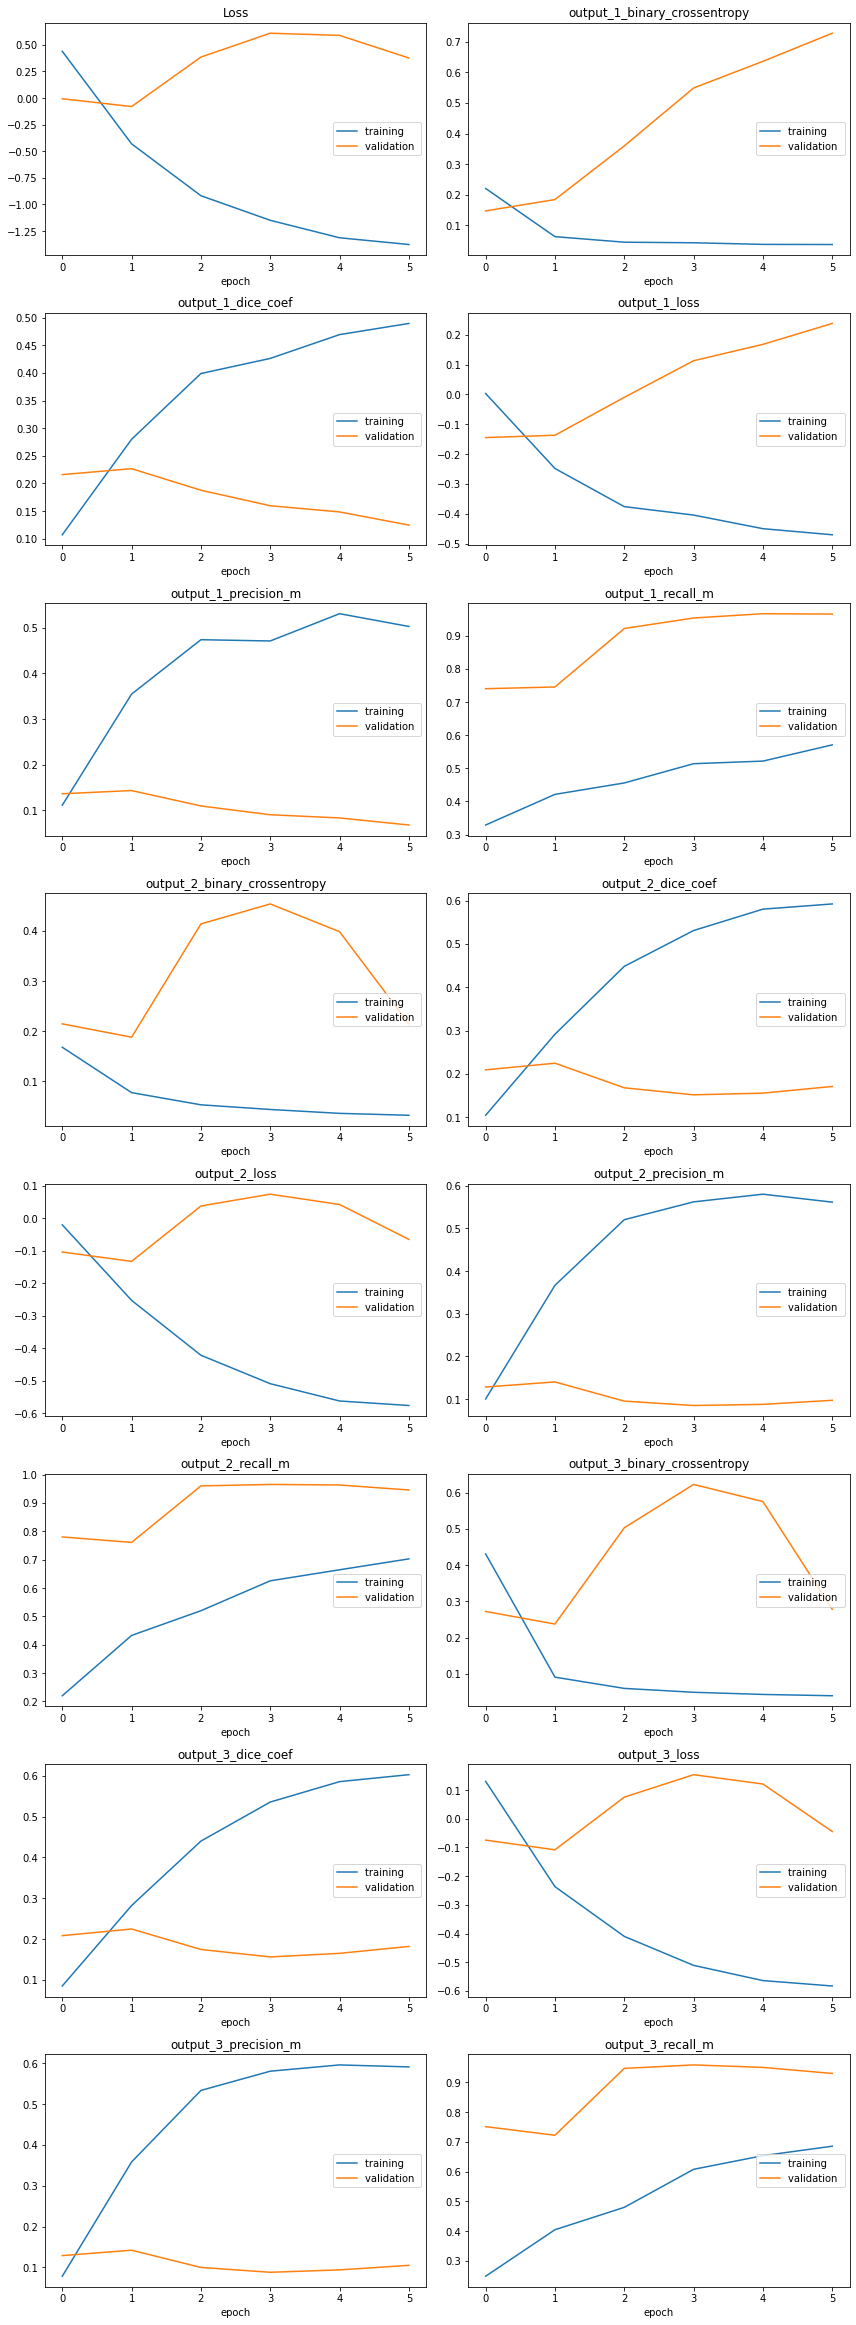

Loss
	training         	 (min:   -2.749, max:    1.015, cur:   -1.377)
	validation       	 (min:   -2.008, max:    2.218, cur:    0.376)
output_1_binary_crossentropy
	training         	 (min:    0.025, max:    0.221, cur:    0.038)
	validation       	 (min:    0.120, max:    2.823, cur:    0.728)
output_1_dice_coef
	training         	 (min:    0.081, max:    0.643, cur:    0.489)
	validation       	 (min:    0.039, max:    0.331, cur:    0.125)
output_1_loss
	training         	 (min:   -0.630, max:    0.012, cur:   -0.471)
	validation       	 (min:   -0.273, max:    1.372, cur:    0.238)
output_1_precision_m
	training         	 (min:    0.078, max:    0.659, cur:    0.502)
	validation       	 (min:    0.020, max:    0.232, cur:    0.068)
output_1_recall_m
	training         	 (min:    0.306, max:    0.705, cur:    0.571)
	validation       	 (min:    0.723, max:    0.976, cur:    0.966)
output_2_binary_crossentropy
	training         	 (min:    0.016, max:    0.226, cur:    0.033)
	valida

KeyboardInterrupt: 

In [24]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = 'UNET_PP_ATT_BCE_DICE'

train(False)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
PROJECT_NAME = 'UNET_PP_ATT1_BCE_DICE'

train(True)

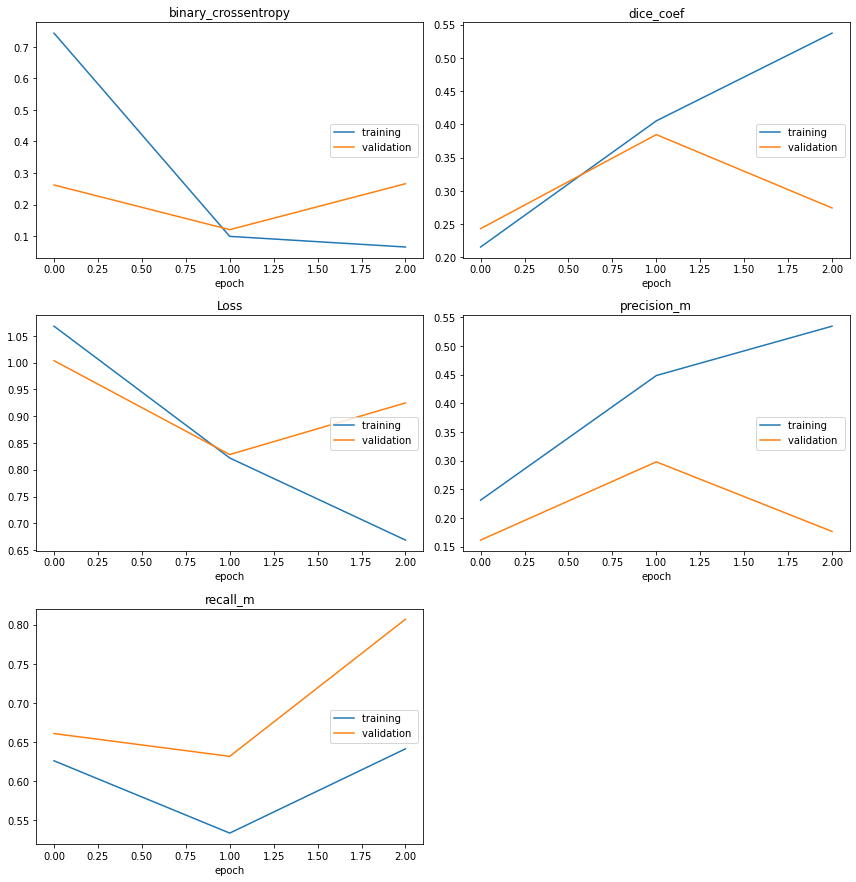

binary_crossentropy
	training         	 (min:    0.065, max:    1.083, cur:    0.065)
	validation       	 (min:    0.120, max:    0.266, cur:    0.266)
dice_coef
	training         	 (min:    0.200, max:    0.537, cur:    0.537)
	validation       	 (min:    0.243, max:    0.385, cur:    0.274)
Loss
	training         	 (min:    0.669, max:    1.090, cur:    0.669)
	validation       	 (min:    0.828, max:    1.003, cur:    0.925)
precision_m
	training         	 (min:    0.220, max:    0.535, cur:    0.535)
	validation       	 (min:    0.162, max:    0.298, cur:    0.177)
recall_m
	training         	 (min:    0.533, max:    0.641, cur:    0.641)
	validation       	 (min:    0.603, max:    0.807, cur:    0.807)
100/100 [==============================] - 519s 5s/step - loss: 0.6688 - binary_crossentropy: 0.0653 - dice_coef: 0.5373 - recall_m: 0.6410 - precision_m: 0.5347 - val_loss: 0.9247 - val_binary_crossentropy: 0.2660 - val_dice_coef: 0.2741 - val_recall_m: 0.8070 - val_precision_m: 0.1

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
PROJECT_NAME = 'UNET_PP_ATT1_DICE'

train(att_input= False, loss_function= dice_coef_loss, retrain = False)